In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import feature
from skimage import filters, feature
from scipy.special import comb
import random
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

path = "Data/data/training_data"


In [2]:
def compute_edges(image, sigma=1.0):
    
    edge_image = feature.canny(image, sigma=sigma)
    return edge_image


In [3]:
def compute_lbp(image, P=8, R=1):

    lbp_image = feature.local_binary_pattern(image, P=P, R=R, method="uniform")
    return lbp_image


In [4]:
def radial_polynomial(n, m, rho):
    result = 0
    for k in range((n - abs(m)) // 2 + 1):
        result += (-1) ** k * comb(n - k, k) * comb((n - 2 * k) // 2, (n - abs(m)) // 2 - k) * rho ** (n - 2 * k)
    return result

def zernike_moment(image, n, m):
    h, w = image.shape
    x, y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    zernike = np.zeros_like(image, dtype=np.complex128)

    valid_indices = rho <= 1

    zernike[valid_indices] = (
        radial_polynomial(n, m, rho[valid_indices]) *
        np.exp(1j * m * theta[valid_indices])
    )

    return np.sum(image * zernike)

def calculate_zernike_moments(image, order):
    h, w = image.shape
    moments = []

    for n in range(order + 1):
        for m in range(-n, n + 1):
            if (n - abs(m)) % 2 == 0:
                moment = zernike_moment(image, n, m)
                moment = np.real(moment)
                moments.append(moment)

    return moments

{'0': 573, '1': 573, '2': 573, '3': 573, '4': 573, '5': 573, '6': 573, '7': 573, '8': 573, '9': 573, 'A': 573, 'B': 573, 'C': 573, 'D': 573, 'E': 573, 'F': 573, 'G': 573, 'H': 573, 'I': 573, 'J': 573, 'K': 573, 'L': 573, 'M': 573, 'N': 573, 'O': 573, 'P': 573, 'Q': 573, 'R': 573, 'S': 573, 'T': 573, 'U': 573, 'V': 573, 'W': 573, 'X': 573, 'Y': 573, 'Z': 573}


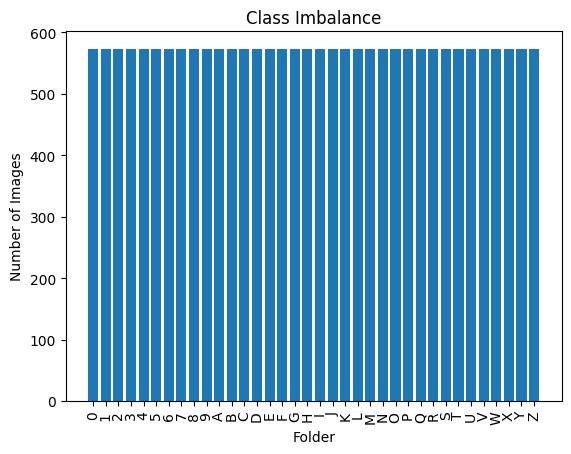

In [5]:

archive_path = 'Data/data/'

d = {}

for root, dirs, files in os.walk(archive_path):
    
    for folder in dirs:

        if folder == "training_data":
            
            testing_data_path = os.path.join(root, folder)
            
            for sub_root, sub_dirs, sub_files in os.walk(testing_data_path):
                
                for sub_folder in sub_dirs:
                    
                    subfolder_path = os.path.join(sub_root, sub_folder)
                    num_images = len(os.listdir(subfolder_path))
                    d[sub_folder] = num_images
                            
print(d)
folders = list(d.keys())
num_images = list(d.values())

plt.bar(folders, num_images)
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.title('Class Imbalance')
plt.xticks(rotation=90)
plt.show()

- from the graph it is clear that there is no class imabalance and 
- each folder contains the same number of images for the test data 
- so there is no need of performing oversampling or undersampling.

In [6]:
class_folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
image_paths = []
for image_dir in class_folders:
    p = [os.path.join(path, image_dir, filename) for filename in os.listdir(os.path.join(path, image_dir)) if filename.endswith(('.jpg', '.png'))]
    image_paths+=p

max_width = 0
max_height = 0
img_widths = []
img_heights = []
for image_path in image_paths:
    with Image.open(image_path) as img:
        width, height = img.size
        img_widths.append(width)
        img_heights.append(height)
        max_width = max(max_width, width)
        max_height = max(max_height, height)

print(f"length of image_paths: {len(image_paths)}\nmax-width: {max_width}\nmax-height: {max_height}")

length of image_paths: 20628
max-width: 92
max-height: 67


The best image width is:  28.0


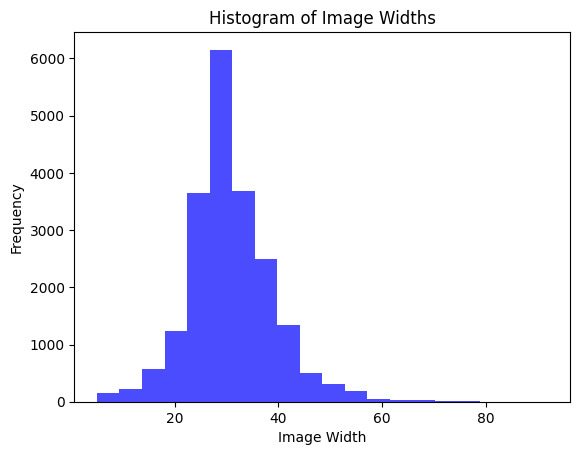

The best image height is:  38.0


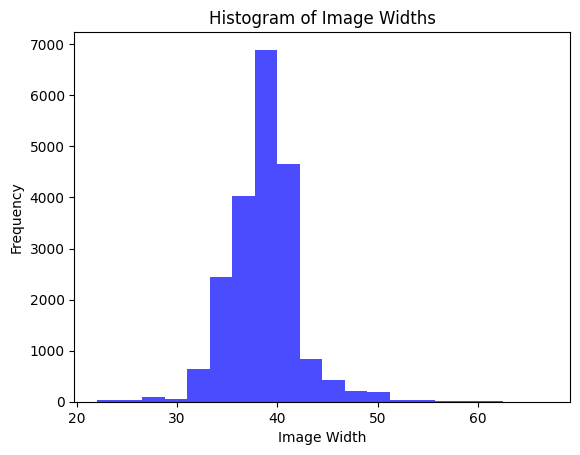

In [7]:
hist, bin_edges = np.histogram(img_widths, bins=20)
max_freq_bin_index = np.argmax(hist)
best_img_width = (bin_edges[max_freq_bin_index] + bin_edges[max_freq_bin_index + 1]) // 2
print("The best image width is: ", best_img_width)

fig, ax = plt.subplots()

ax.hist(img_widths, bins=20, color='blue', alpha=0.7)

ax.set_xlabel('Image Width')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Image Widths')

plt.show()

hist, bin_edges = np.histogram(img_heights, bins=20)
max_freq_bin_index = np.argmax(hist)
best_img_height = (bin_edges[max_freq_bin_index] + bin_edges[max_freq_bin_index + 1]) // 2
print("The best image height is: ", best_img_height)

fig, ax = plt.subplots()

ax.hist(img_heights, bins=20, color='blue', alpha=0.7)

ax.set_xlabel('Image Width')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Image Widths')

plt.show()



In [8]:
#Image Resizing

output_path = 'resized_archive' 
 
os.makedirs(output_path, exist_ok=True)

for root, dirs, files in os.walk(archive_path):

    relative_path = os.path.relpath(root, archive_path)
    output_dir = os.path.join(output_path, relative_path)
    os.makedirs(output_dir, exist_ok=True)

    for file in files:

        input_image_path = os.path.join(root, file)
        output_image_path = os.path.join(output_dir, file)

        with Image.open(input_image_path) as img:
            img = img.resize((38, 38), Image.LANCZOS)
            img.save(output_image_path)

print(f"The best size to reshape all the images to is: ({max(best_img_height, best_img_width)}, {max(best_img_height, best_img_width)})")

The best size to reshape all the images to is: (38.0, 38.0)


In [9]:
# Color Conversion --> convert everything to grey scale


resized_archive_path = 'resized_archive'
final_archive_path = 'final_archive'  


os.makedirs(final_archive_path, exist_ok=True)

edge_map_dict = {}

lbp_map_dict = {}

for root, dirs, files in os.walk(resized_archive_path):

    relative_path = os.path.relpath(root, resized_archive_path)
    final_dir = os.path.join(final_archive_path, relative_path)
    os.makedirs(final_dir, exist_ok=True)

    for file in files:

        if file.endswith('.jpg') or file.endswith('.png'):
            input_image_path = os.path.join(root, file)
            output_image_path = os.path.join(final_dir, file)

            with Image.open(input_image_path) as img:
                img = img.convert('L')
                img.save(output_image_path)
                
                img_array = np.array(img)
                
                edge_img = compute_edges(img_array)
            
                label = os.path.basename(root)
                if label not in edge_map_dict:
                    edge_map_dict[label] = []
                edge_map_dict[label].append(edge_img)


                lbp_img = compute_lbp(img_array)
                if label not in lbp_map_dict:
                    lbp_map_dict[label] = []
                lbp_map_dict[label].append(lbp_img)
                
                       

In [10]:
def calculate_mean_and_variance(path, target_size=(38, 38)):
    d = {}
    class_paths = [os.path.join(path, name) for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
    for class_path in class_paths:
        class_name = class_path.split('/')[-1][-1]
        images_in_class = [os.path.join(class_path, name) for name in os.listdir(class_path)]
        imgs_mean = []
        imgs_var = []
        for img_path in images_in_class:
            img = Image.open(img_path)
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            img_array = np.array(img)
            img_mean = img_array.mean()
            img_var = img_array.var()
            imgs_mean.append(img_mean)
            imgs_var.append(img_var)
        imgs_mean = np.array(imgs_mean)
        imgs_var = np.array(imgs_var)
        class_mean = np.mean(imgs_mean, axis=0) # MEAN ACROSS THE IMG CHANNEL DIM
        class_variance = np.var(imgs_var, axis=0) # VAR ACROSS THE IMG CHANNEL DIM
        class_std_dev = np.sqrt(class_variance)
        mean_and_var = {
            "mean": class_mean,
            "variance": class_variance,
            "std_dev": class_std_dev
        }
        d[class_name] = mean_and_var
    return d

across_channels = calculate_mean_and_variance(path, (38, 38))
across_channels

{'0': {'mean': 144.0479483014508,
  'variance': 4927868.882294726,
  'std_dev': 2219.88037567224},
 '1': {'mean': 153.659057398249,
  'variance': 4912310.573575002,
  'std_dev': 2216.3732929213443},
 '2': {'mean': 151.5998776909206,
  'variance': 4666643.913205211,
  'std_dev': 2160.2416330598785},
 '3': {'mean': 153.7819562684612,
  'variance': 5012536.408642244,
  'std_dev': 2238.869448771465},
 '4': {'mean': 157.3227364360198,
  'variance': 5200490.02471805,
  'std_dev': 2280.4582926942667},
 '5': {'mean': 148.94603534877425,
  'variance': 4421695.499136985,
  'std_dev': 2102.7827988494164},
 '6': {'mean': 146.13494244705177,
  'variance': 4788871.214303934,
  'std_dev': 2188.3489699551883},
 '7': {'mean': 165.25050156391254,
  'variance': 5125319.831142986,
  'std_dev': 2263.9169223147273},
 '8': {'mean': 137.32651448129832,
  'variance': 4101351.23032594,
  'std_dev': 2025.1793081912376},
 '9': {'mean': 145.6864222418819,
  'variance': 4825207.994165853,
  'std_dev': 2196.63560796

The means of all the classes present in this dataset are similar from this we can infer: 
- The dataset is well-balanced
- These classes have similar statistical characteristics or properties. This means that the classes represent entities with similar underlying features.
- Similar standard deviations suggest that the data points within different classes exhibit comparable levels of variability or dispersion around their respective means. 

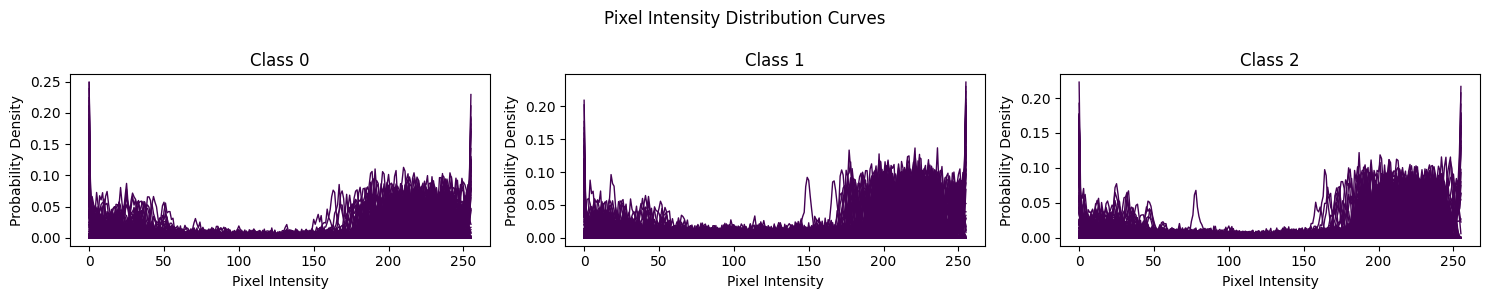

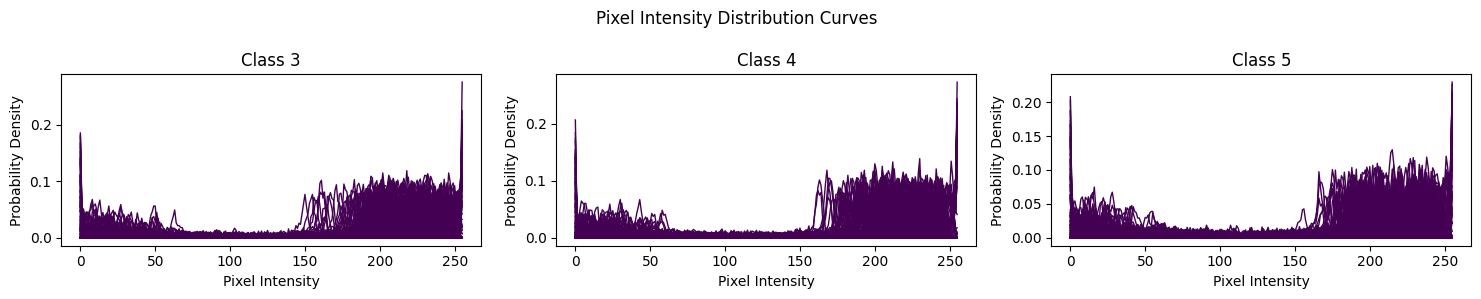

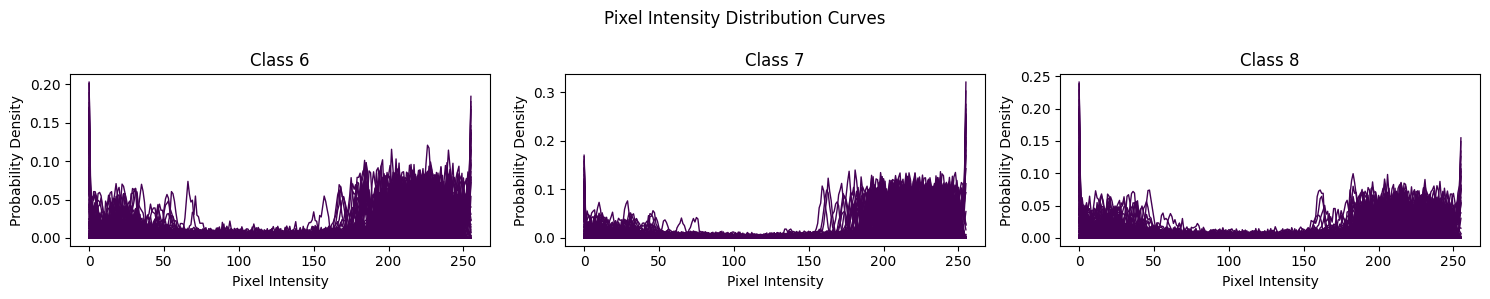

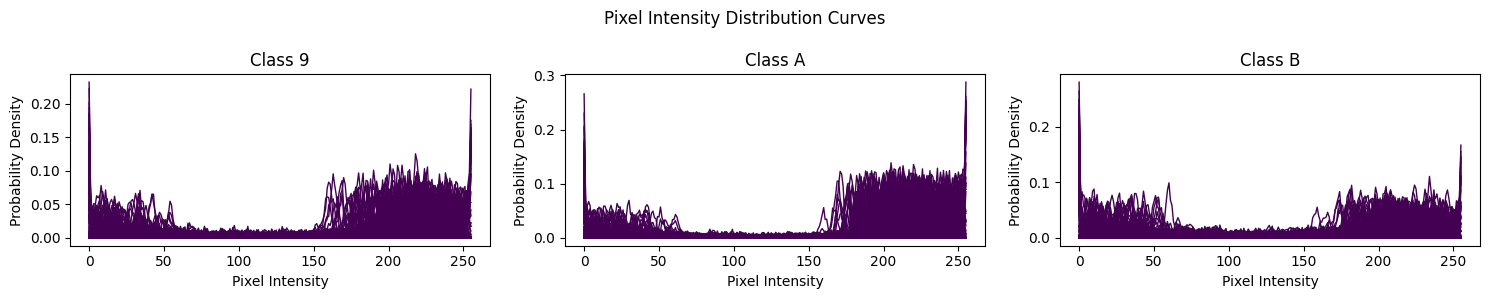

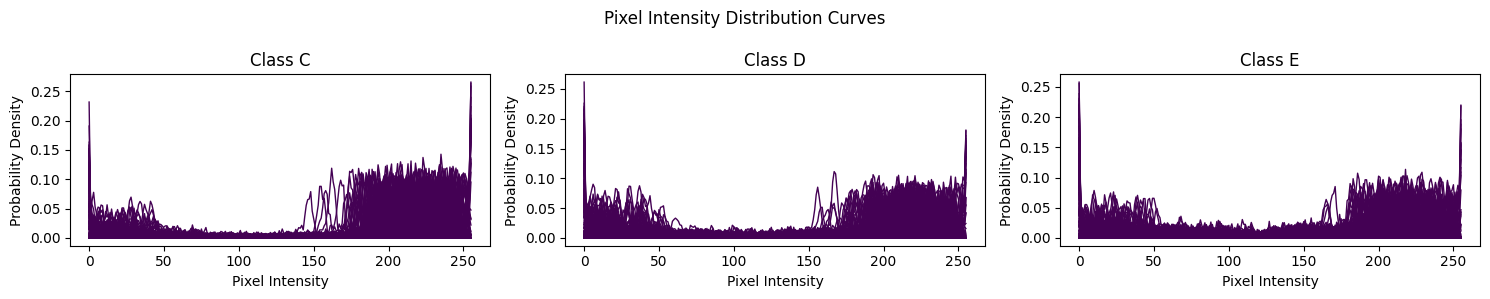

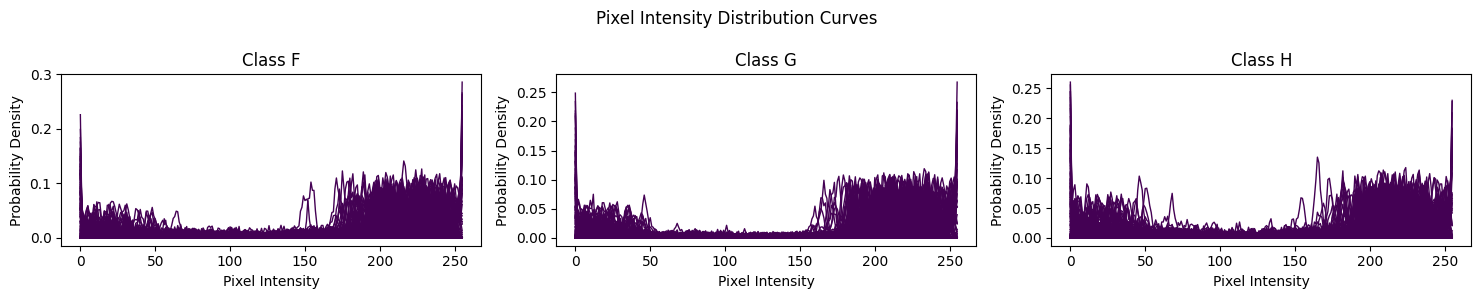

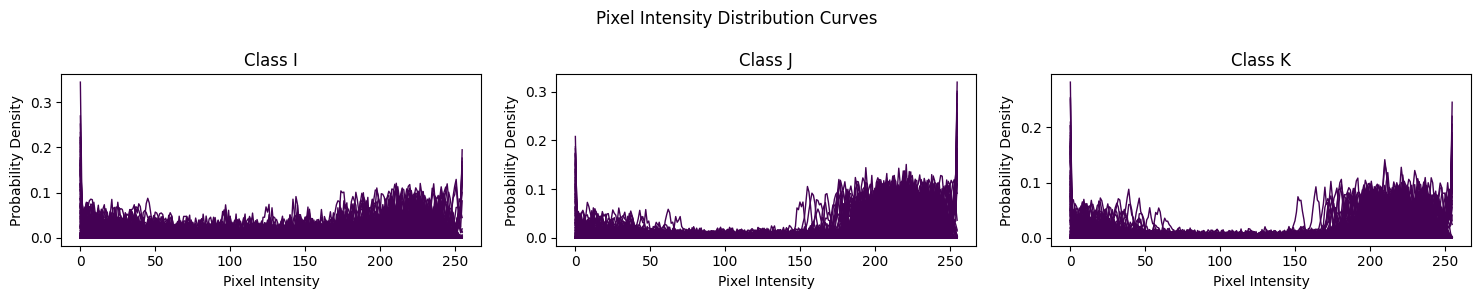

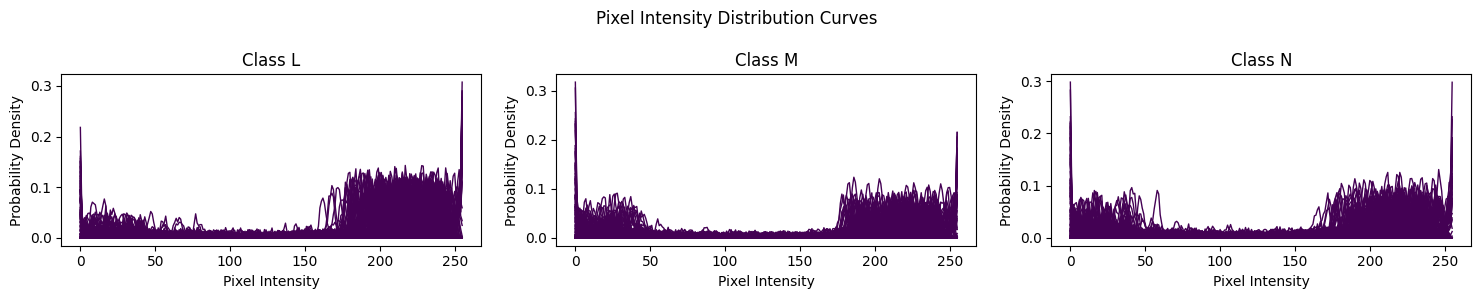

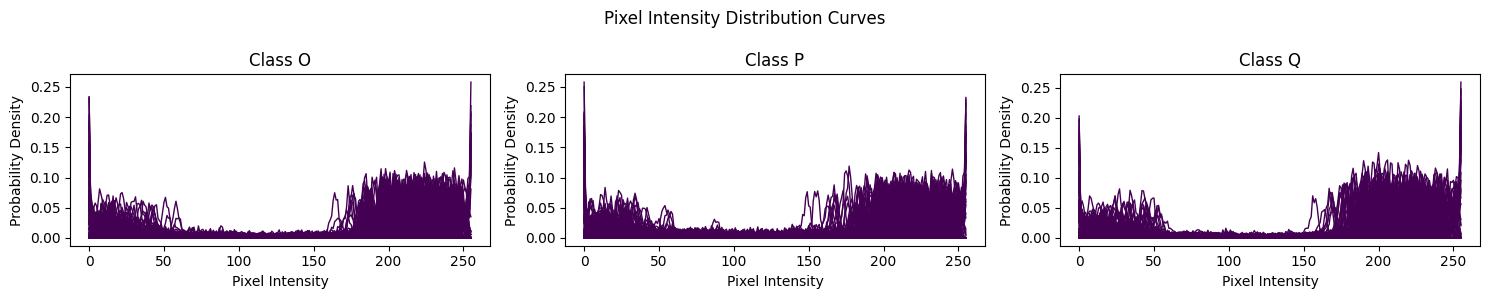

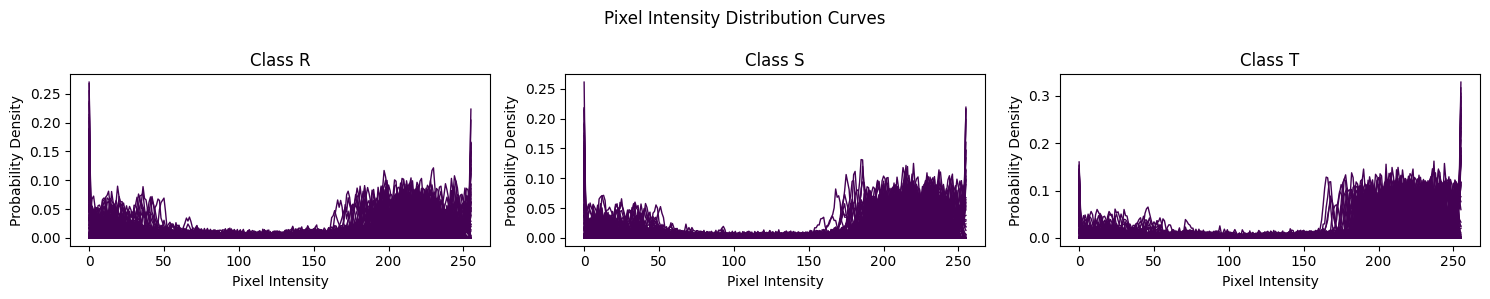

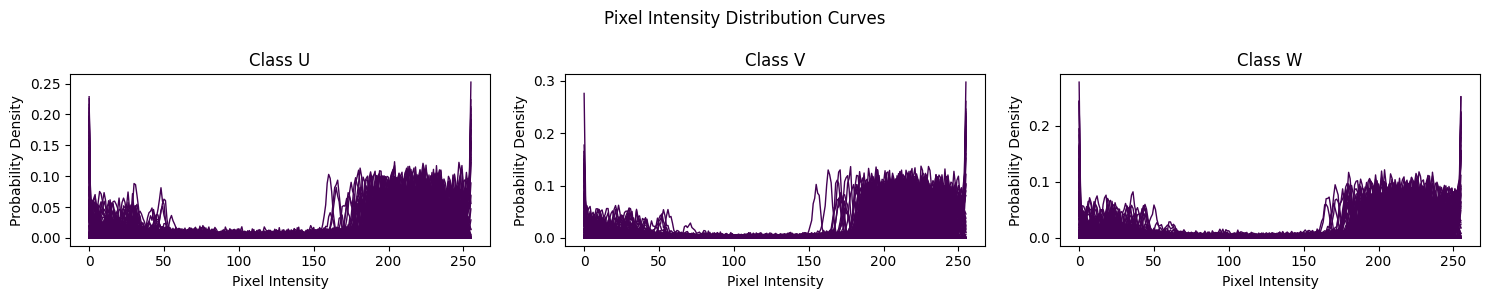

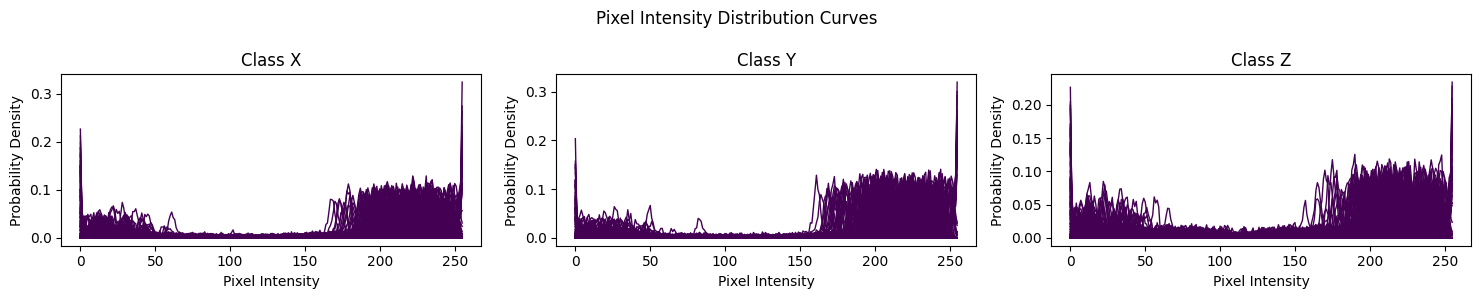

In [11]:
classwise_imgs_paths = []
for image_dir in class_folders:
    
    p = [path+'/'+image_dir+'/'+filename for filename in os.listdir(os.path.join(path, image_dir)) if filename.endswith(('.jpg', '.png'))]
    
    classwise_imgs_paths.append(p)

num_cols = 3

num_rows = (len(classwise_imgs_paths) + num_cols - 1) // num_cols

for i in range(num_rows):
    fig, axs = plt.subplots(1, num_cols, figsize=(15, 3))
    fig.suptitle('Pixel Intensity Distribution Curves')

    for j, img_paths in enumerate(classwise_imgs_paths[i * num_cols:(i + 1) * num_cols]):
        ax = axs[j]
        ax.set_title(f"Class {img_paths[0].split('/')[-2]}")

        for img_p in img_paths:
            img = Image.open(img_p)
            img_arr = np.array(img)
            pixel_values = img_arr.flatten()

            hist, bin_edges = np.histogram(pixel_values, bins=256, range=(0, 256))

            pdf = hist / np.sum(hist)

            color = plt.get_cmap('viridis')(float(j) / len(img_paths))  # You can change the color map
            ax.plot(bin_edges[0:-1], pdf, color=color, lw=1)

        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Probability Density')

    plt.tight_layout()
    plt.show()

It is clear from the above graphs that all the images in a class have similar pixel intensity curves from which we can infer the images in the class have a consistent distribution of pixel intensities.

In [12]:
testing_d = "final_archive/testing_data/"
training_d = "final_archive/training_data/"

zernike_dictionary = {}

for foldr in os.listdir(testing_d):
    foldr_path = testing_d+foldr
    index_range = range(0, 28)
    random_indices = random.sample(index_range, 3)
    all_images = os.listdir(foldr_path)
    random_three = []
    arr = []
    for ind in random_indices:
        random_three.append(all_images[ind])
    for image_name in random_three:
        img_path = foldr_path + "/" + image_name 
        img = Image.open(img_path)
        img_array = np.array(img)
        order = 5
        zernike_moments = calculate_zernike_moments(img_array, order)
        arr.append(zernike_moments)
    zernike_dictionary[foldr] = arr

zernike_dictionary

{'0': [[125442.0,
   -1552.5945945945869,
   -1552.5945945945869,
   -1868.8911614317012,
   -76444.6676406136,
   -1868.8911614317012,
   -878.7738534736343,
   711.0875959962787,
   711.0875959962787,
   -878.7738534736343,
   2120.5492719142053,
   7064.279092351193,
   9708.958202630394,
   7064.279092351193,
   2120.5492719142053,
   159.7781658753631,
   2491.727058725536,
   2556.6850280263125,
   2556.6850280263125,
   2491.727058725536,
   159.7781658753631],
  [81993.0,
   -2307.432432432427,
   -2307.432432432427,
   -139.57048940832647,
   -52427.277574872176,
   -139.57048940832647,
   -737.0569561526463,
   1636.721378792957,
   1636.721378792957,
   -737.0569561526463,
   2681.115483675095,
   4455.151436829599,
   13320.481947388718,
   4455.151436829599,
   2681.115483675095,
   205.10131401933197,
   2228.5510625821375,
   2217.989274061766,
   2217.989274061766,
   2228.5510625821375,
   205.10131401933197],
  [182722.0,
   -1169.7837837837728,
   -1169.7837837837728

Zernike moments are useful for characterizing and quantifying the spatial frequency components and geometrical features like average intensity or brightness, asymmetry, skewness, shape characteristics, rotational asymmetry, etc of an image.

From the zernike moments we can see that the elements of similar looking shape has some similar values that represents the shape characteristics of those elements. Other such properties can be verified by closely observing the dataset and mapping the values.

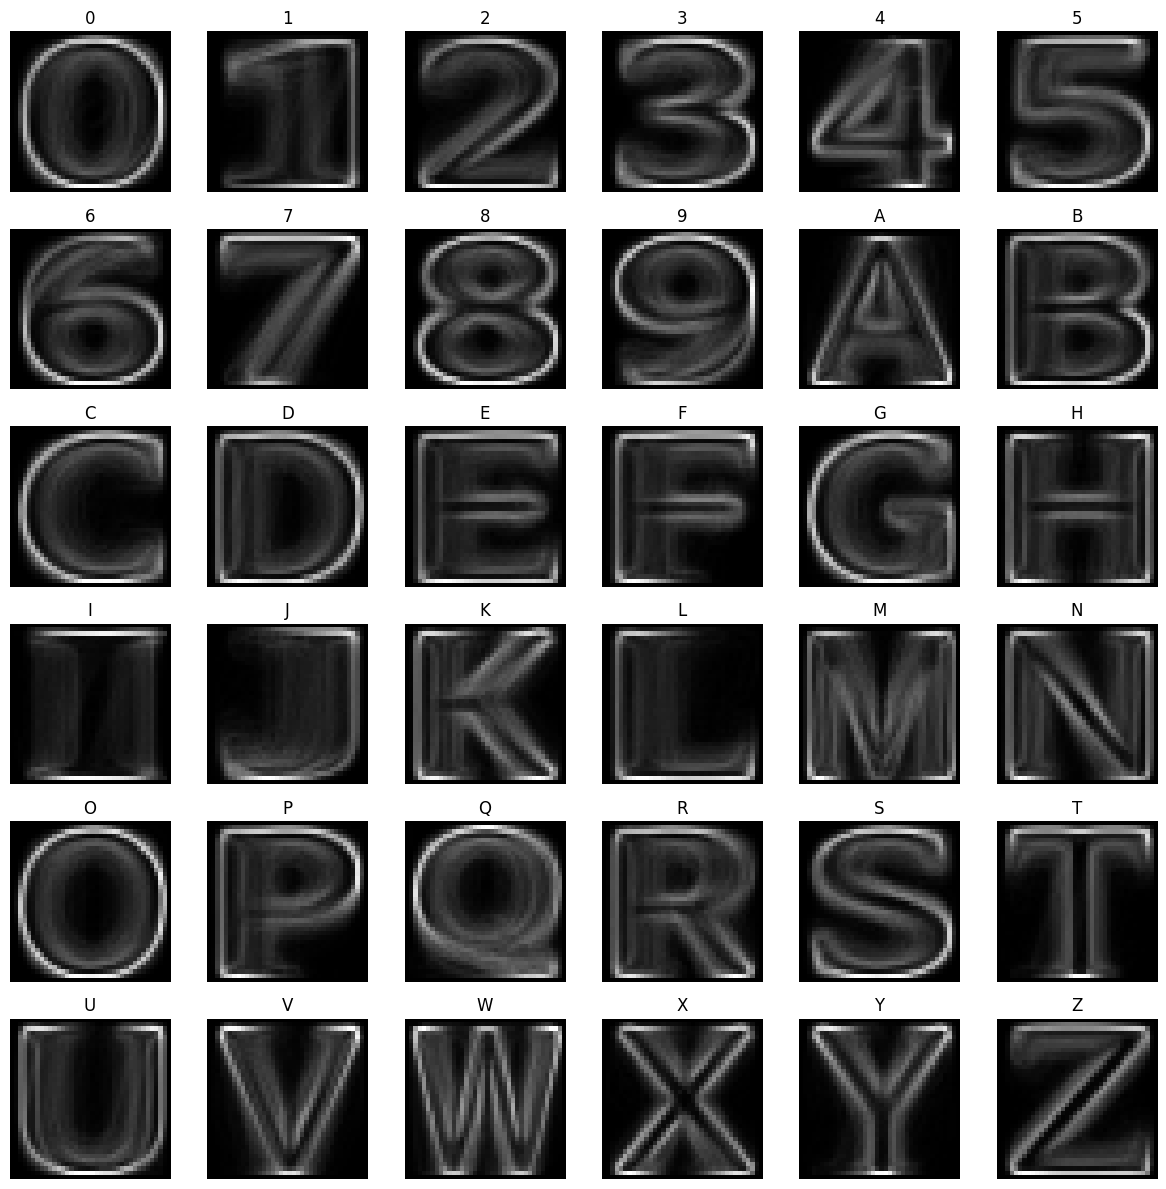

In [13]:
# Plotting the mean Edge Detected Image

fig, axs = plt.subplots(6, 6, figsize=(12, 12)) 
axs = axs.ravel()

for idx, (label, edge_images) in enumerate(edge_map_dict.items()):
    mean_edge_image = np.mean(edge_images, axis=0)
    axs[idx].imshow(mean_edge_image, cmap='gray')
    axs[idx].set_title(label)
    axs[idx].axis('off')

plt.tight_layout()
plt.show()        
         

By looking at the Images of each class after performing the Edge Detection we can infer the following 

There are distinctive Edge Patterns among the classes : 
Each character and digit presents a unique edge pattern. 
The sharpness, continuity, and layout of these edges are distinctive for each class. 
For instance, the number "8" has two clear circular patterns, 
while the letter "A" has a distinct peak with a horizontal crossbar in the middle.
That is 
A has a continuous Edge patterns where in case of a digit Number 8 has not a straight edge pattern but instead 
a circular edge pattern. This can help us in differentiate between class 8 and class A similarly it can be 
extended to other classes as well.

Hence It is very crucial to study the Edge patterns in differnet classes.

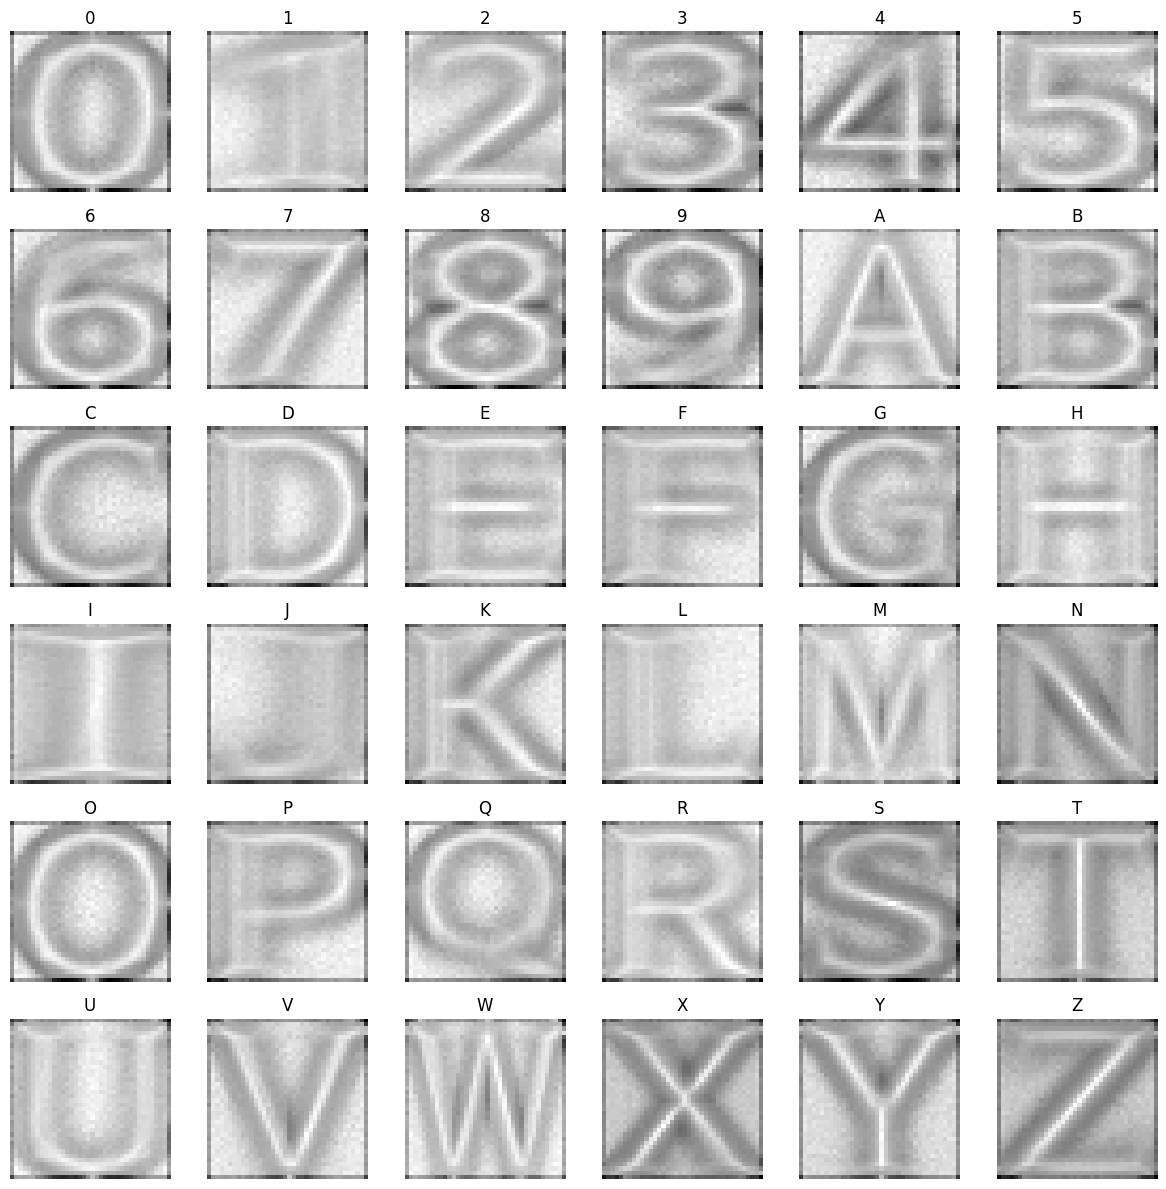

In [14]:
# plotting the LBP images

fig, axs = plt.subplots(6, 6, figsize=(12, 12)) 
axs = axs.ravel()

for idx, (label, lbp_images) in enumerate(lbp_map_dict.items()):
    mean_lbp_image = np.mean(lbp_images, axis=0)
    axs[idx].imshow(mean_lbp_image, cmap='gray')
    axs[idx].set_title(label)
    axs[idx].axis('off')

plt.tight_layout()
plt.show()      

LBP provides a compact representation of the image, 
where the local patterns can be captured with just a few bits per pixel. 
This reduces the dimensionality of the data, making it quicker and often more accurate for classification tasks.

In [15]:

final_archive_path = 'final_archive/training_data'

data = []

for root, dirs, files in os.walk(final_archive_path):
    
    for file in files:

        label = os.path.basename(root)

        image_path = os.path.join(root, file)
        with Image.open(image_path) as img:

            pixel_values = list(img.getdata())


            data.append(pixel_values + [label])

columns = [f'pixel_{i}' for i in range(len(data[0]) - 1)] + ['label']
df = pd.DataFrame(data, columns=columns)

In [16]:
def normalize_pixels(pixel_values):
    return pixel_values / 255.0


grouped = df.groupby('label')

grouped_df = {}

norm_data_map = {}

for label, group in grouped:
    
    df_normalized = group.copy()

    pixel_intensity_columns = group.columns[:-1]  # Exclude the 'label' column
    
    df_normalized[pixel_intensity_columns] = df[pixel_intensity_columns].apply(normalize_pixels)
    df_normalized['label'] = group['label']
    
    norm_data_map[label] = df_normalized
    
    grouped_df[label] = df_normalized
    
df= pd.concat(norm_data_map.values(), ignore_index=True)

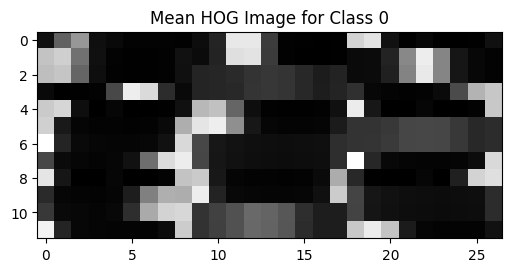

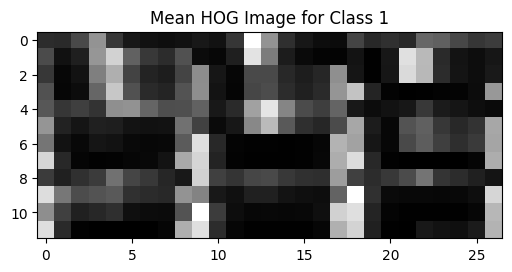

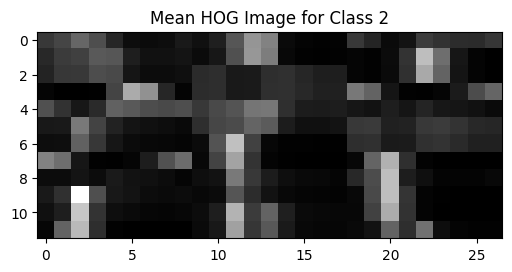

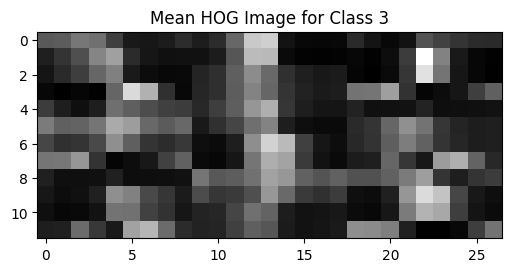

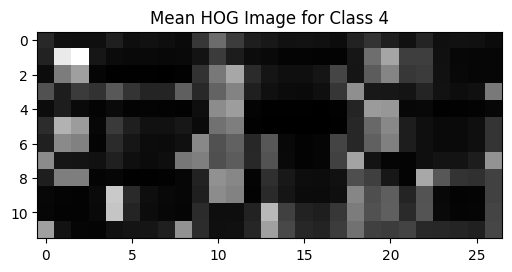

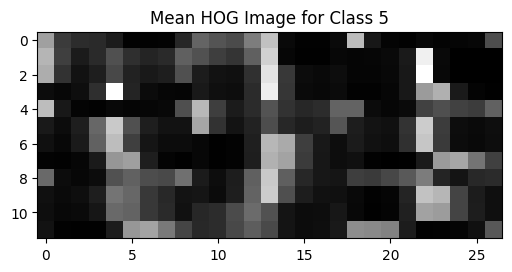

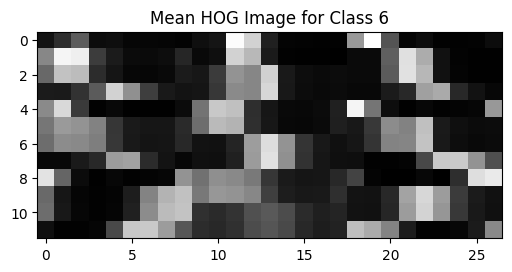

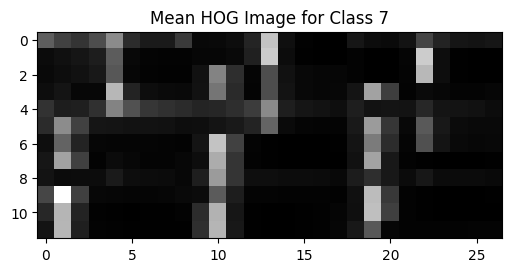

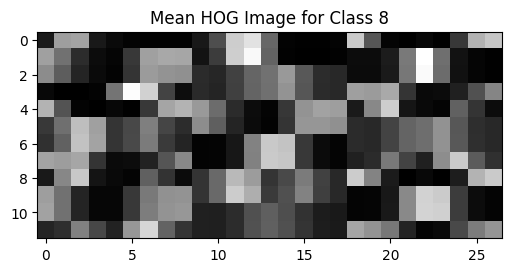

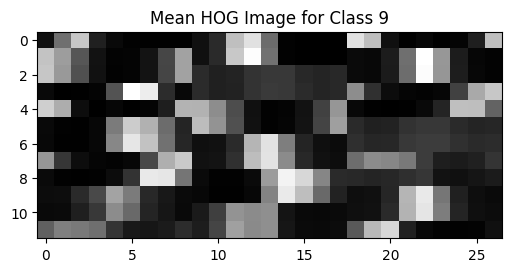

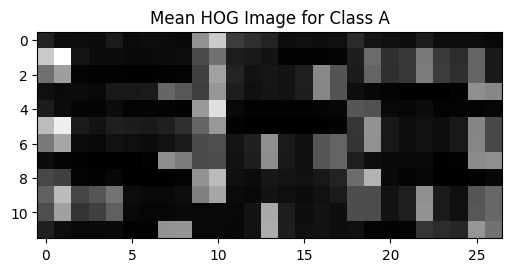

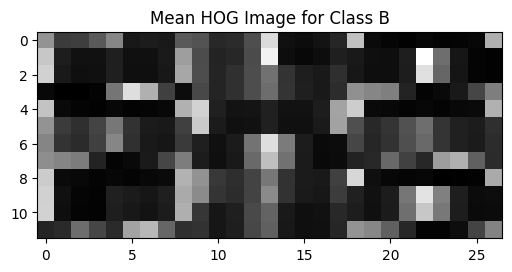

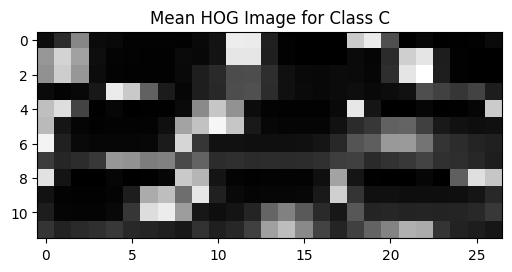

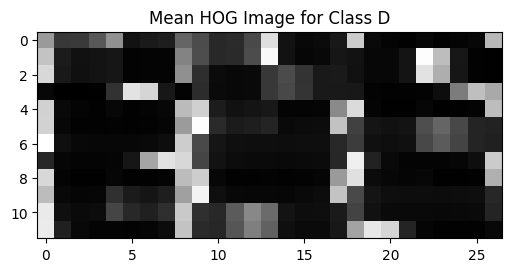

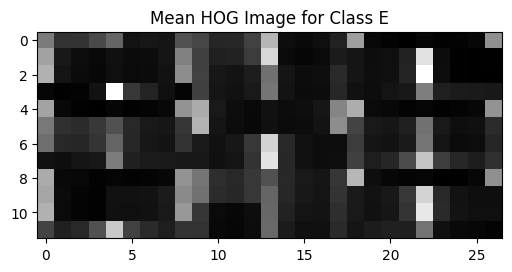

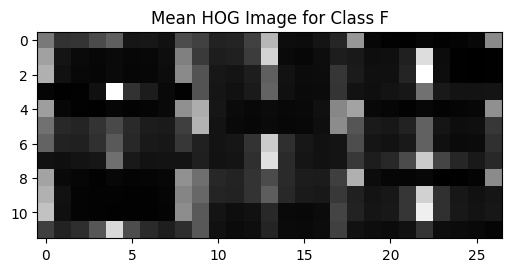

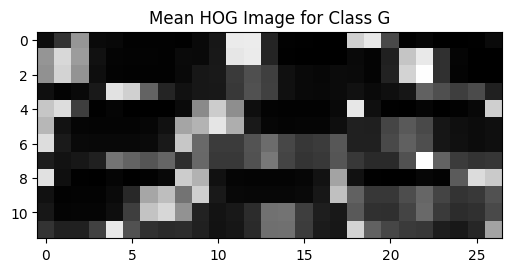

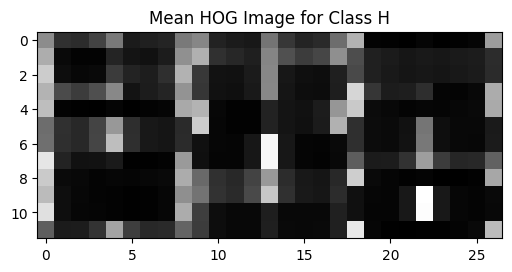

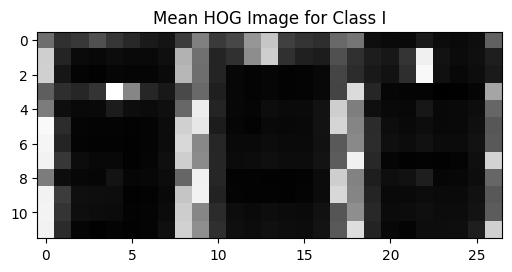

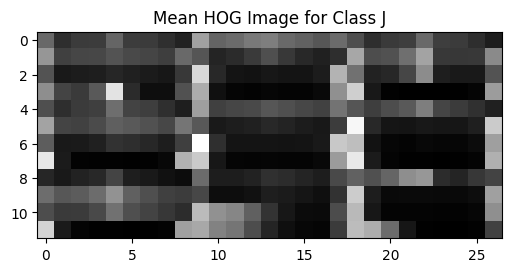

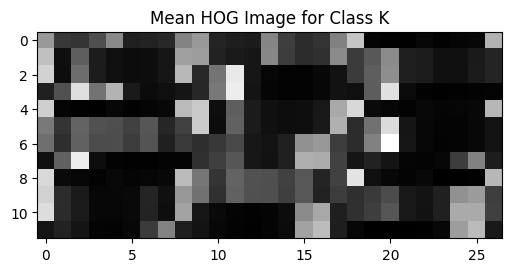

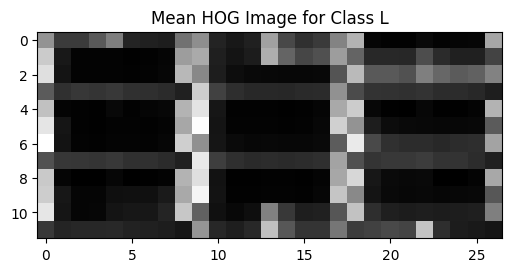

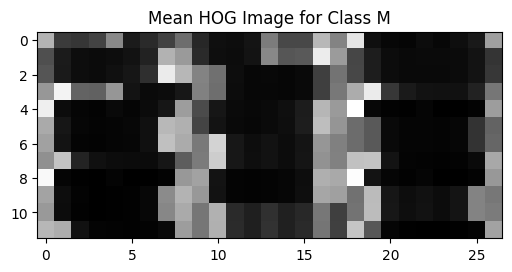

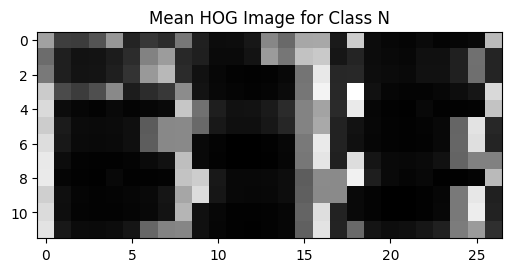

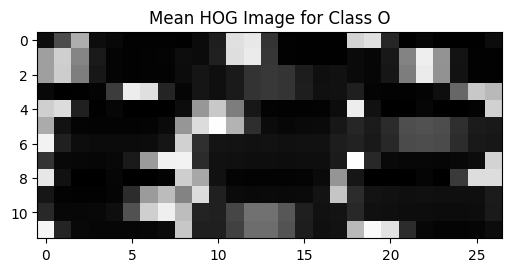

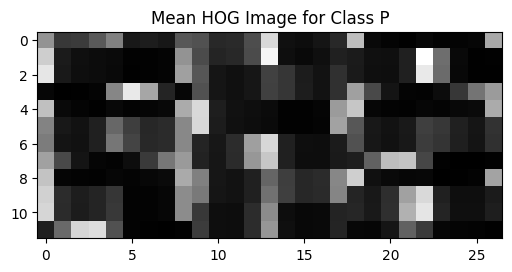

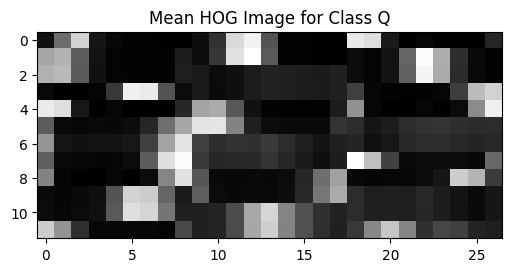

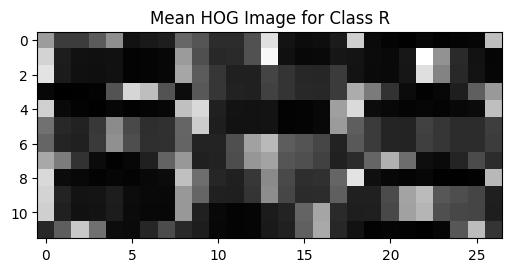

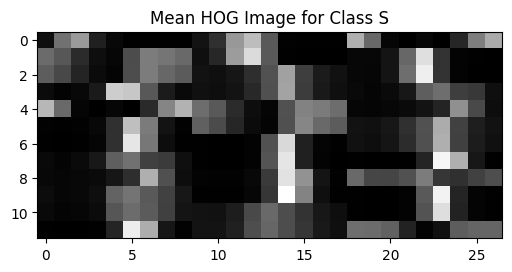

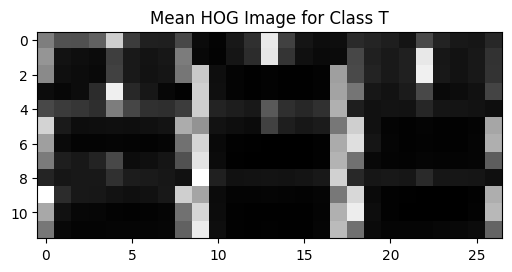

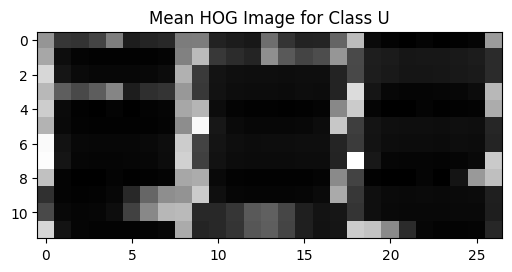

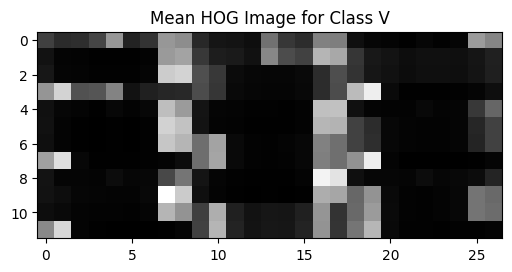

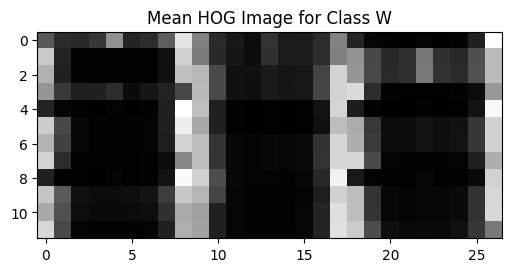

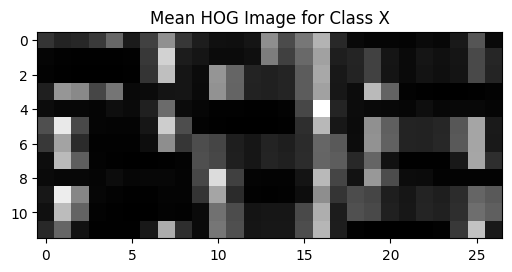

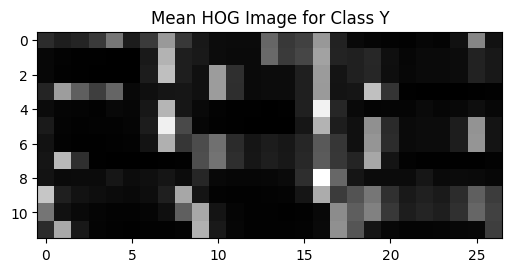

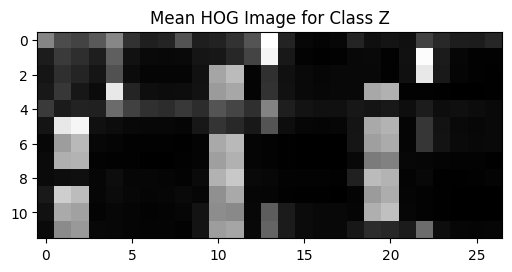

In [17]:
hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'visualize': False  
}


mean_hog_images_by_class = {}

for label, group_df in grouped_df.items():

    hog_features = []

    for i, row in group_df.iterrows():
        
        image_data = np.array(row[:-1]).reshape((38, 38))  
        features = hog(image_data, **hog_params)

        hog_features.append(features)

    mean_hog_features = np.mean(hog_features, axis=0)

    mean_hog_image = mean_hog_features.reshape((12, 27))

    mean_hog_images_by_class[label] = mean_hog_image


for label, mean_hog_image in mean_hog_images_by_class.items():
    plt.figure(figsize=(6, 6))
    plt.imshow(mean_hog_image, cmap=plt.cm.gray)
    plt.title(f'Mean HOG Image for Class {label}')
    plt.show()


HOG analysis helps us in analysing the noise in the images 

Intensity of the Gradients: HOG captures the intensity of gradients. 
Areas with very faint gradients that don't match the general structure of the digit 
could be a result of noise.

very light or inconsistently dark patches might be indications of areas with 
less meaningful information or noise.

Consider a scenario where I am trying to classify class 7 and class 8.
There is sufficient amount of noise in class 7 that can help me classify between class 7 and class 8

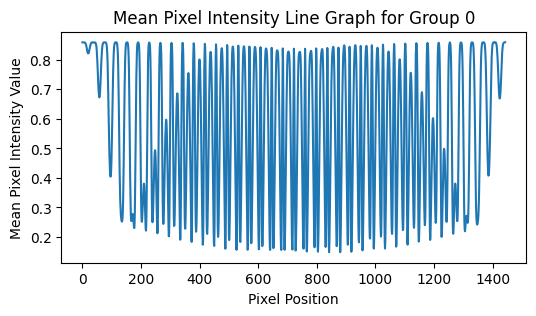

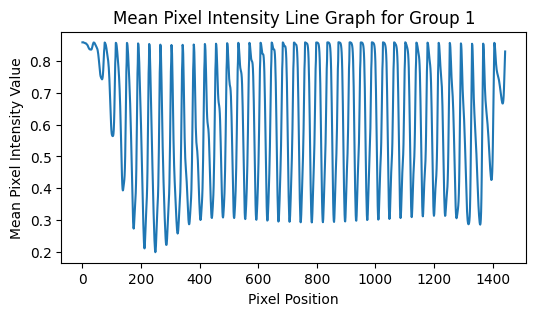

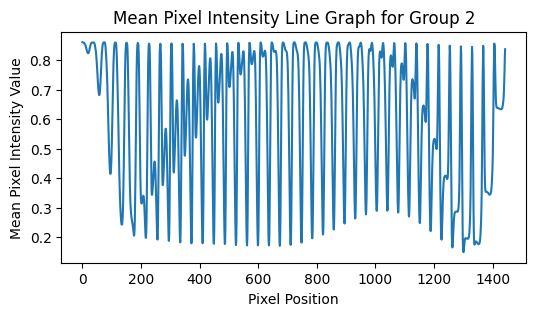

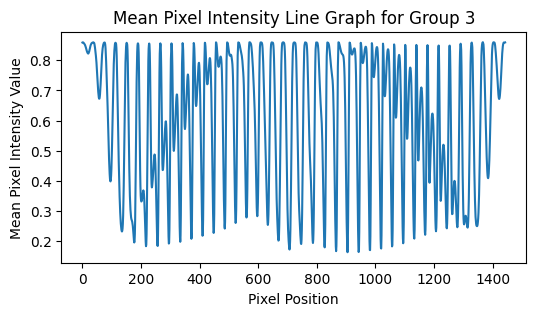

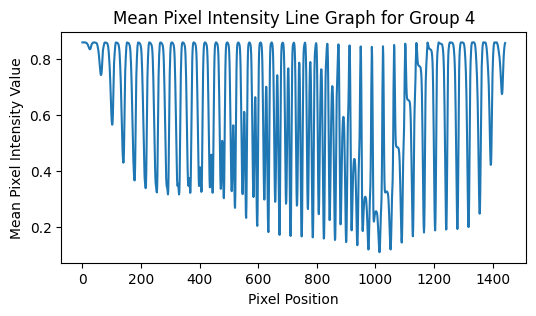

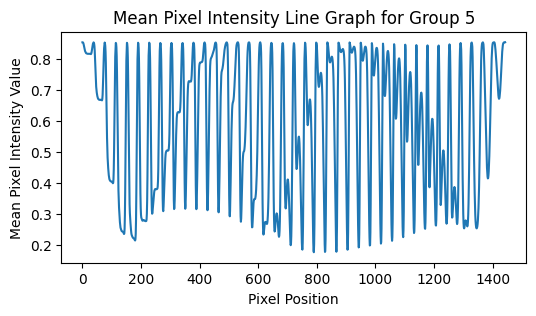

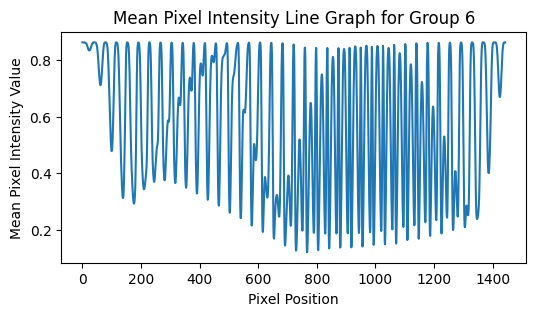

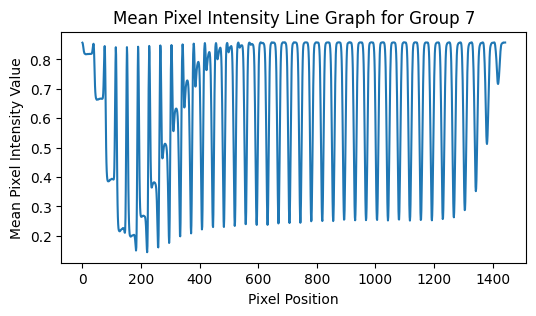

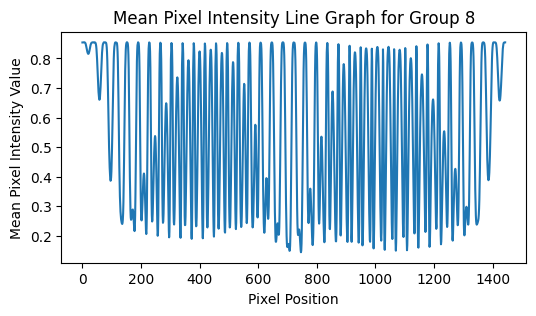

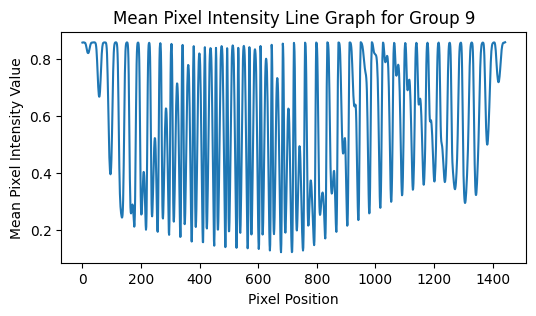

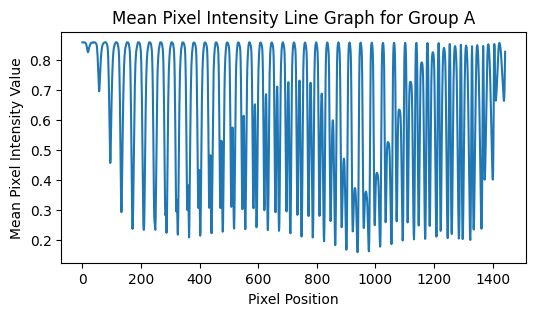

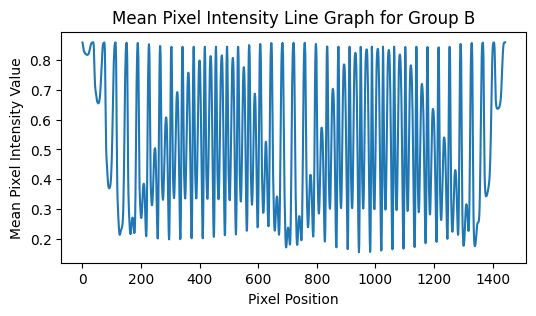

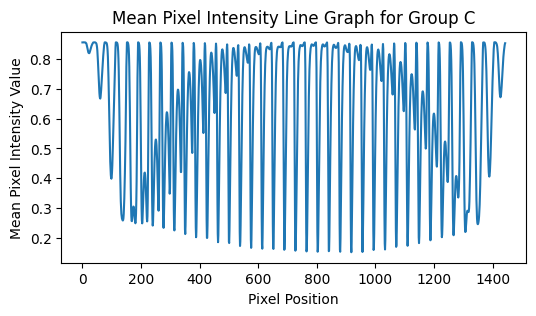

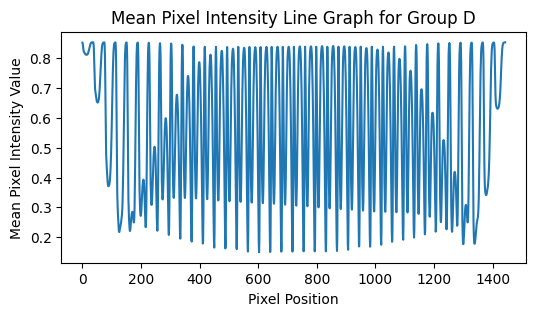

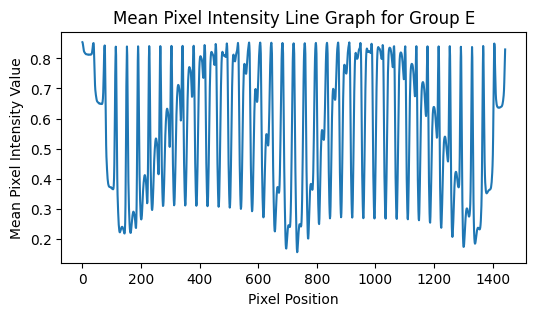

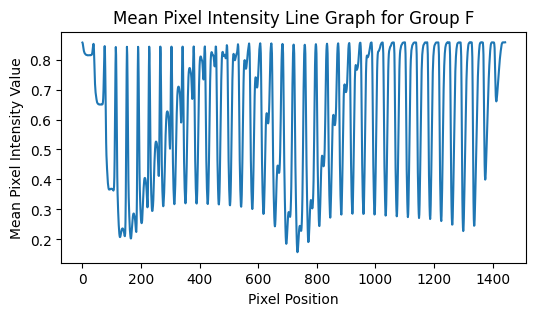

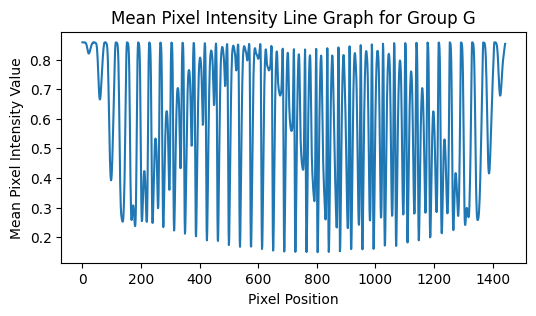

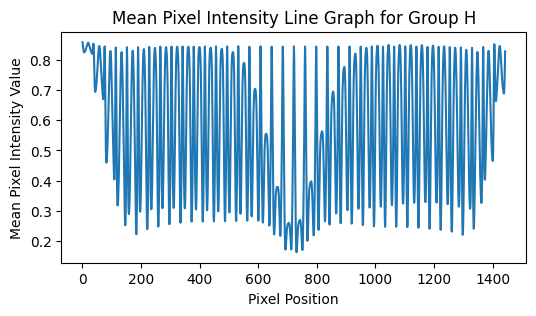

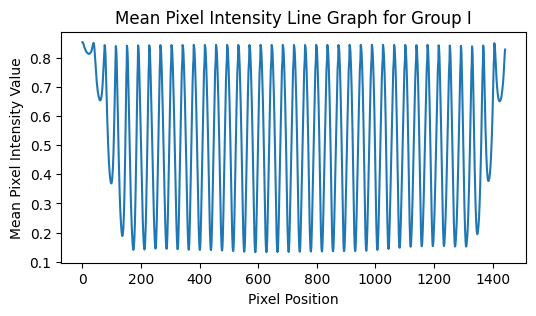

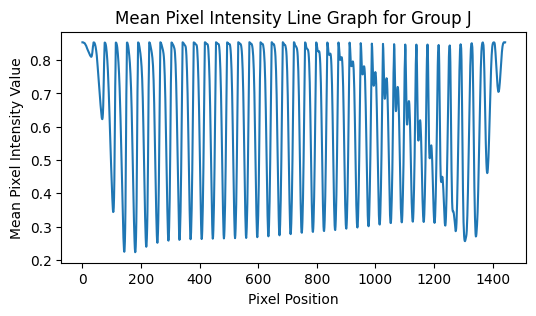

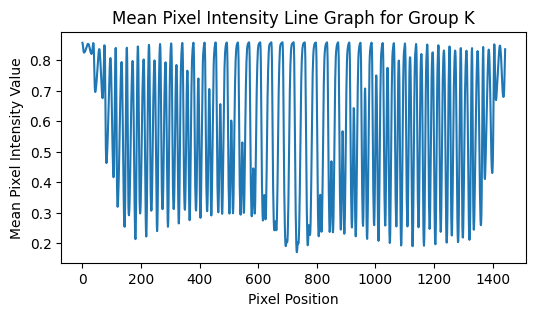

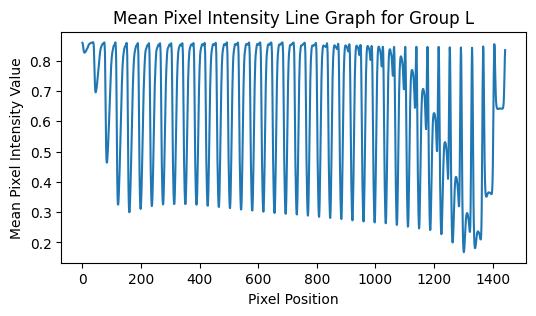

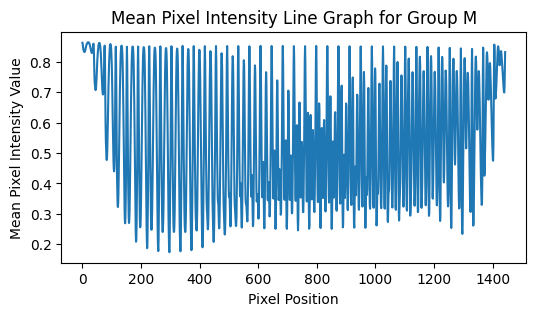

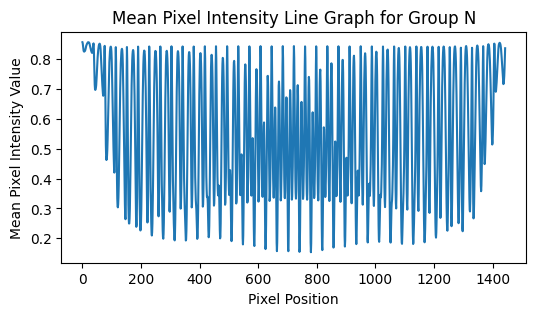

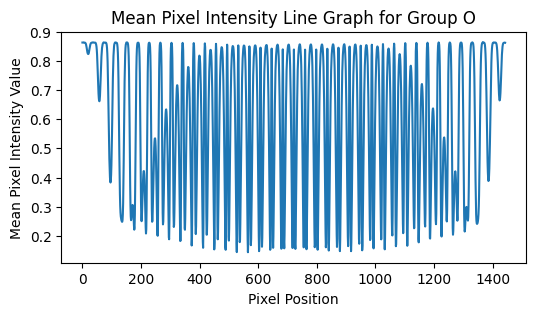

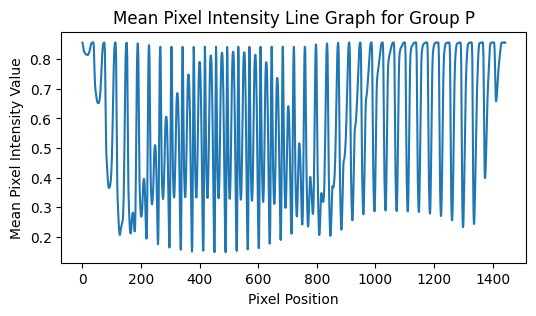

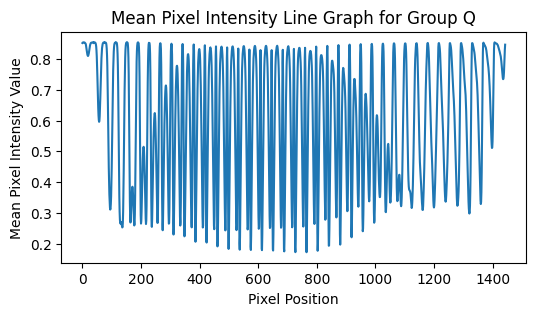

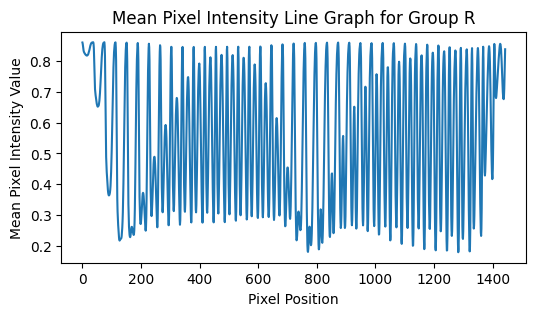

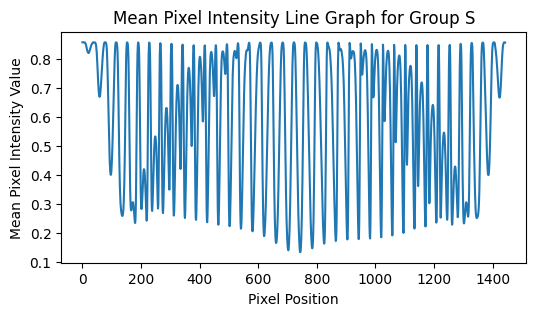

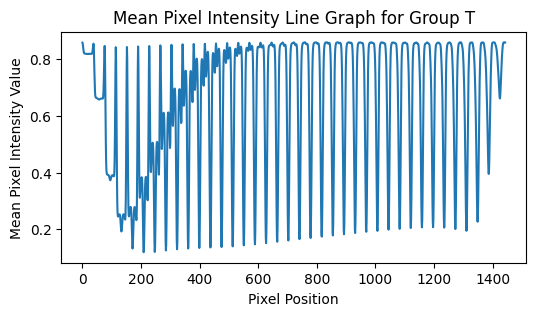

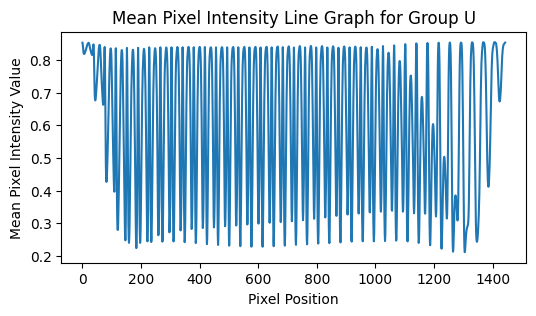

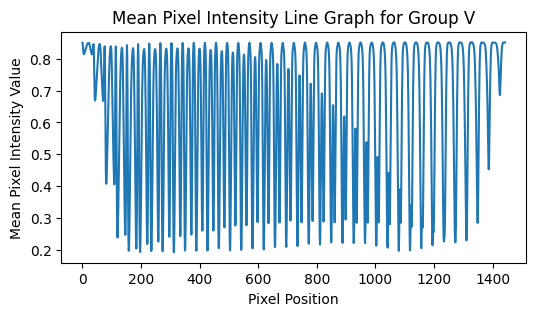

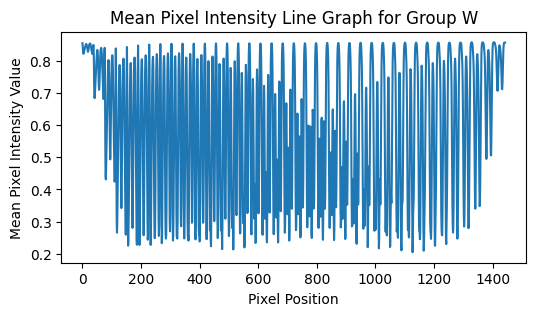

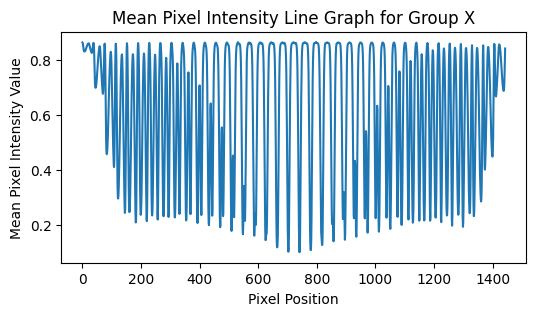

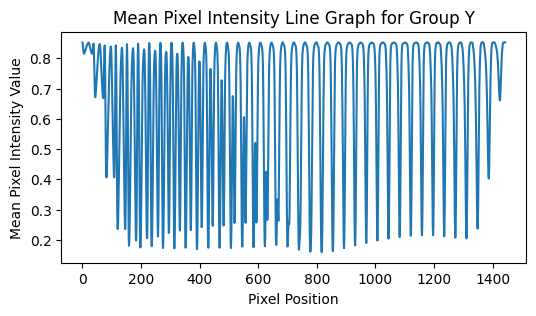

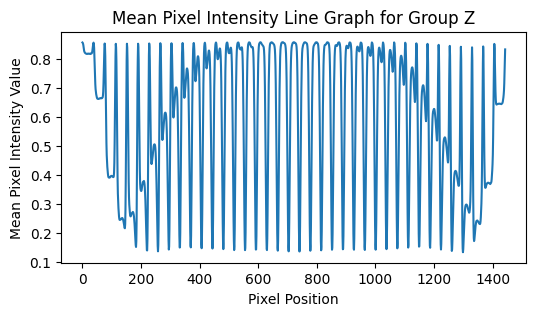

In [18]:
line_graphs = []

for label, group_df in grouped_df.items():

    all_pixel_values = []
    all_intensity_values = []

    for i, row in group_df.iterrows():
        image_data = np.array(row[:-1])
        pixel_values = np.arange(len(image_data))  


        all_pixel_values.append(pixel_values)
        all_intensity_values.append(image_data)


    mean_intensity_values = np.mean(all_intensity_values, axis=0)

    plt.figure(figsize=(6, 3))
    plt.plot(all_pixel_values[0], mean_intensity_values)
    plt.title(f'Mean Pixel Intensity Line Graph for Group {label}')
    plt.xlabel('Pixel Position')
    plt.ylabel('Mean Pixel Intensity Value')
    plt.show()
    
    line_graphs.append((all_pixel_values[0], mean_intensity_values))

Here we can see individual class wise mean pixel intensity.
When it comes to classification of characeter/digits Pixel Intensity graphs 
provide insights into the distribution of pixel values (intensities) in an image.

It helps us in classification in the folloing ways:
The positions and heights of peaks in the histogram can provide information about the dominant pixel values, 
which might be characteristic of certain classes of objects or patterns.

For example: Consider the case when you try to classify 8 and 9 
Now look at the peak intensities graph of their respective classes. 

If we closely observe certain pixel positions, we can notice differences between the two graphs:

Around pixel positions 200-800: Group 9 seems to have a generally higher intensity fluctuation than Group 8.
After position 800: Group 8 has higher pixel intensity fluctuations than group 9.

Hence by analysing peak intensity fluctuation we can classify between classes easily.

In [19]:
data = []
class_l = []
for c in classwise_imgs_paths:
    for image_p in c:
        img = Image.open(image_p)
        img = img.resize((38, 38), Image.Resampling.LANCZOS)
        img_arr = np.array(img).flatten() / 255.0
        cl = image_p.split("/")[-2]
        class_l.append(cl)
        data.append(img_arr)

data_df = pd.DataFrame(data)
labels_df = pd.DataFrame(class_l)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_df.values)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21917821 0.13958581 0.07113834]


In [20]:
data_df['First Dimension'] = pca_result[:,0]
data_df['Second Dimension'] = pca_result[:,1] 
data_df['Third Dimension'] = pca_result[:,2]

Text(0.5, 0.98, '3-Component PCA')

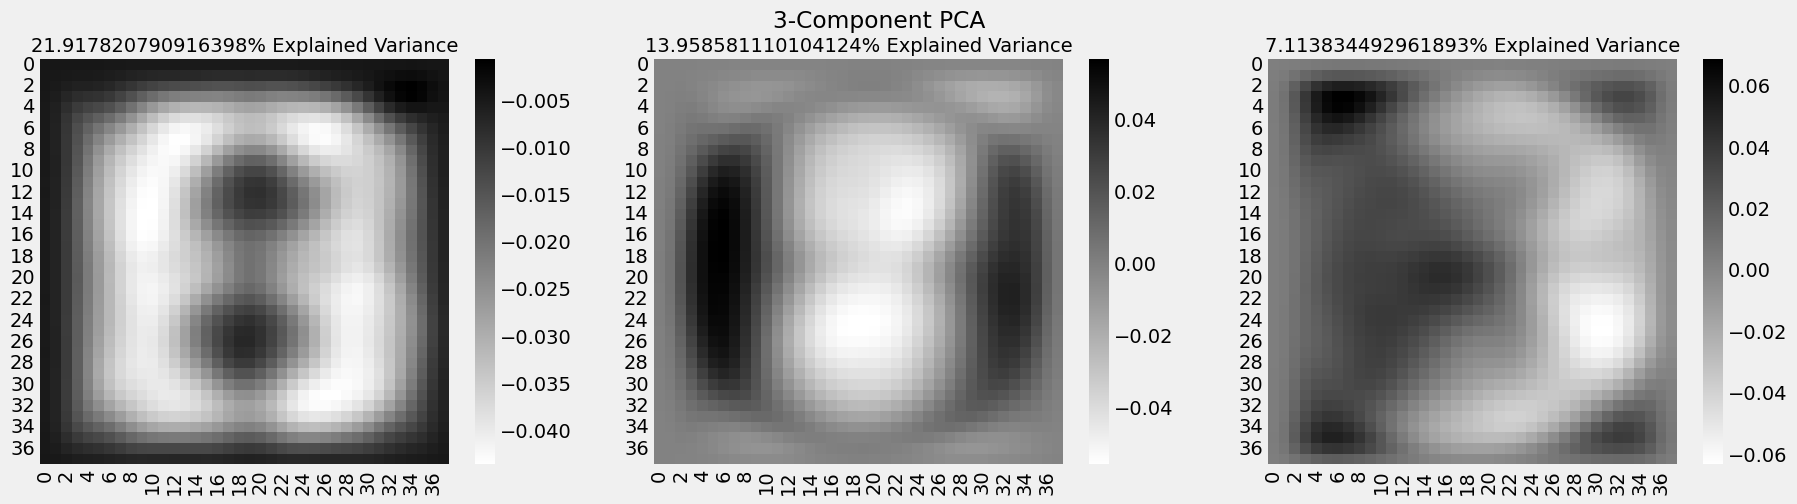

In [21]:
plt.style.use('fivethirtyeight')
fig, axarr = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(pca.components_[0, :].reshape(38, 38), ax=axarr[0], cmap=plt.cm.binary)
sns.heatmap(pca.components_[1, :].reshape(38, 38), ax=axarr[1], cmap=plt.cm.binary)
sns.heatmap(pca.components_[2, :].reshape(38, 38), ax=axarr[2], cmap=plt.cm.binary)

axarr[0].set_title(f"{pca.explained_variance_ratio_[0]*100}% Explained Variance", fontsize=14)
axarr[1].set_title(f"{pca.explained_variance_ratio_[1]*100}% Explained Variance", fontsize=14)
axarr[2].set_title(f"{pca.explained_variance_ratio_[2]*100}% Explained Variance", fontsize=14)
plt.suptitle('3-Component PCA')

We can see that thefirst component explains about 22% of the variance in the dataset, we can prety clearly see a shape that is common in classes like - B, H, 8 and so on. The 2nd component that explains about 14% of the variance shows curves like in 0 and O and some other clases as well. Each subsequent component explains less and less of the variation in the data.

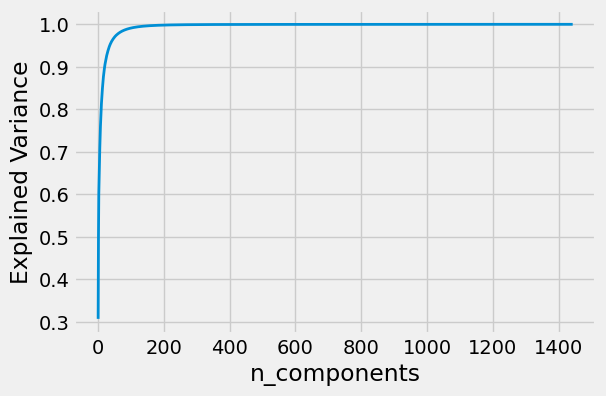

In [22]:
pca = PCA(n_components=1444)
pca_result_784 = pca.fit_transform(data_df.values)
var_ratios = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(var_ratios, linewidth=2)
plt.xlabel("n_components")
plt.ylabel("Explained Variance")
plt.show()

We can see from the above graph that 100% of the variance of the data can be explained by just 200 components, this suggests that many of the original 1444 features may be linear combinations of each other. In other words, we have a high degree of dimensionality in our dataset, but much of the information can be effectively captured in a lower-dimensional space, exponentially decreasing the computational overhead while training. So we can reduce our data to 200 dimensional wihtout significant loss of information.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20628 samples in 0.122s...
[t-SNE] Computed neighbors for 20628 samples in 7.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20628
[t-SNE] Computed conditional probabilities for sample 2000 / 20628
[t-SNE] Computed conditional probabilities for sample 3000 / 20628
[t-SNE] Computed conditional probabilities for sample 4000 / 20628
[t-SNE] Computed conditional probabilities for sample 5000 / 20628
[t-SNE] Computed conditional probabilities for sample 6000 / 20628
[t-SNE] Computed conditional probabilities for sample 7000 / 20628
[t-SNE] Computed conditional probabilities for sample 8000 / 20628
[t-SNE] Computed conditional probabilities for sample 9000 / 20628
[t-SNE] Computed conditional probabilities for sample 10000 / 20628
[t-SNE] Computed conditional probabilities for sample 11000 / 20628
[t-SNE] Computed conditional probabilities for sample 12000 / 20628
[t-SNE] Computed conditional probabilities for sa

C:\Users\7c40j\AppData\Local\Temp\ipykernel_8084\3749414789.py:10: UserWarning: 
The palette list has fewer values (10) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='t-SNE First Dimension', ylabel='t-SNE Second Dimension'>

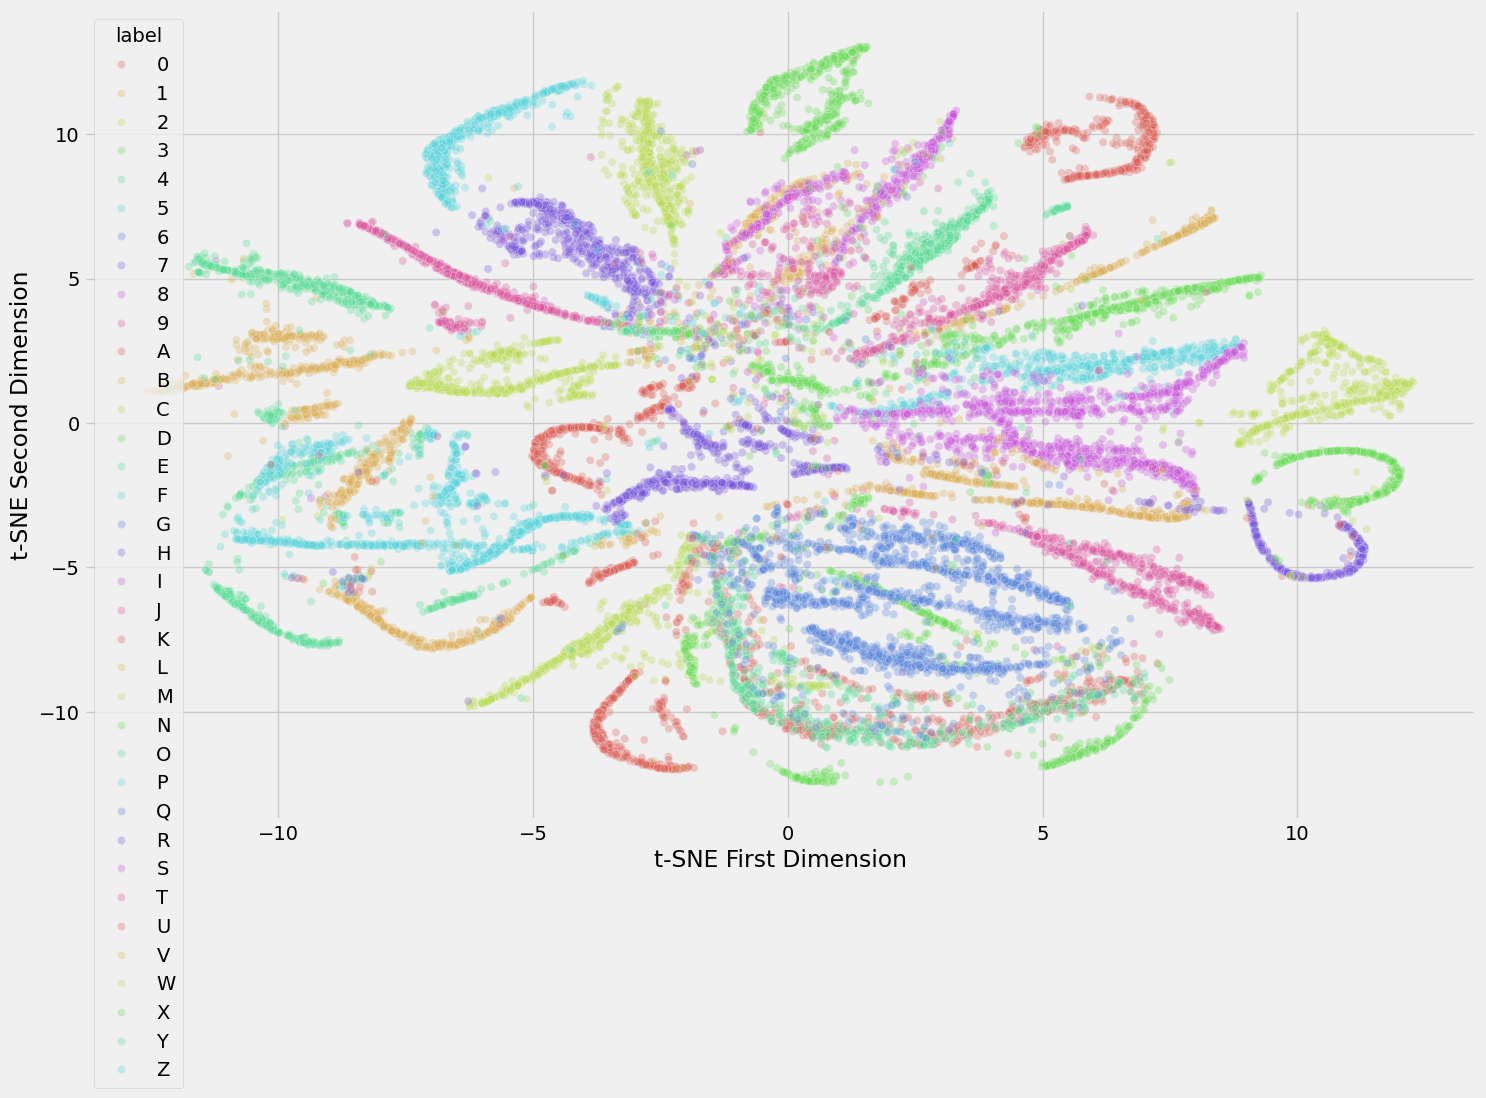

In [23]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
data_df.columns = data_df.columns.astype(str)
tsne_results = tsne.fit_transform(data_df)
labels_df = labels_df.rename(columns={0: 'label'})
data_df_w_labels = pd.concat([data_df, labels_df], axis=1)

data_df_w_labels['t-SNE First Dimension'] = tsne_results[:,0]
data_df_w_labels['t-SNE Second Dimension'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="t-SNE First Dimension", y="t-SNE Second Dimension",
    hue="label",
    hue_order = labels_df["label"].unique(),
    palette=sns.color_palette("hls", 10),
    data=data_df_w_labels,
    legend="full",
    alpha=0.3
)

From the above graph we can see that each category is clearly clustered in its own distinct region